In [ ]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using Plots
using ProgressMeter
using OrdinaryDiffEq

We are interested in simulating the Lorenz attractor
            $$ ẋ = \sigma(y - x)\\
       ẏ = x(\rho-z) - y\\
       ż = xy - \beta z$$

Define parameters of the Lorenz attractor

In [259]:
function lorenz(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

# u0 = [1.508870; -1.531271; 25.46091]
u0 = [1.0; 0.0; 0.0]
tspan = (0.0,40.0)
prob = ODEProblem(lorenz,u0,tspan)
sol = solve(prob)

Δt = 1e-3
T = tspan[1]:Δt:tspan[end]
integrator = init(prob, RK4(), adaptive =false, dt = Δt, save_everystep=false)

t: 0.0
u: 3-element Array{Float64,1}:
 1.0
 0.0
 0.0

In [260]:
states = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.0, 0.0, 0.0]

In [261]:
for t in T[1:end-1]
    step!(integrator)
    push!(states, deepcopy(integrator.u))
end

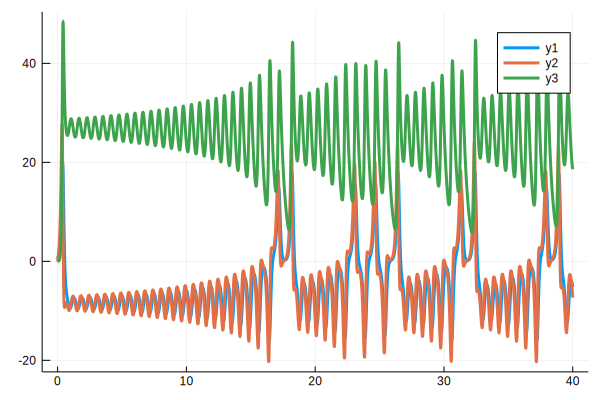

In [262]:
plot(T, hcat(states...)[1,:], linewidth  = 3)
plot!(T, hcat(states...)[2,:], linewidth = 3)
plot!(T, hcat(states...)[3,:], linewidth = 3)

Define propagation function fprop

In [263]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        set_t!(integrator, deepcopy(t))
        set_u!(integrator, deepcopy(s))
        step!(integrator)
        ENS.S[i] = deepcopy(integrator.u)

    end
    print(ENS)
    return ENS
end

In [264]:
fprop = PropagationFunction()

PropagationFunction()

In [265]:
ens

EnsembleState{500,Array{Float64,1}}(Array{Float64,1}[[2.07725, -0.784162, 24.7153], [3.43109, -0.081107, 25.4267], [0.403468, -0.711182, 25.8735], [2.37819, -1.99707, 23.7151], [2.73346, -2.00479, 24.3307], [-0.716115, -3.26773, 23.3279], [3.21235, -0.663668, 28.8126], [-0.707726, -2.34135, 26.2834], [3.04976, 1.29586, 25.4848], [0.189427, -1.14988, 25.0503]  …  [1.61594, -3.44213, 25.4505], [4.64193, -0.308117, 28.1478], [2.37519, -3.28109, 25.3848], [1.91624, -2.23585, 21.7944], [1.5037, -4.28885, 22.6534], [-0.115985, -2.92877, 24.3558], [1.35399, -1.09538, 23.2502], [-0.167371, -3.81307, 25.7513], [1.2338, -1.19064, 23.3767], [-0.4429, -2.41723, 26.6813]])

In [266]:
fprop(0.0, ens)

EnsembleState{500,Array{Float64,1}}(Array{Float64,1}[[2.04882, -0.776536, 24.6479], [3.39619, -0.0721303, 25.3587], [0.392385, -0.709611, 25.8043], [2.33471, -1.98491, 23.6472], [2.68638, -1.99276, 24.2605], [-0.741505, -3.26789, 23.2682], [3.17378, -0.665472, 28.7338], [-0.723975, -2.34027, 26.2151], [3.03234, 1.3023, 25.4209], [0.176109, -1.14819, 24.9834], [-0.638995, 0.578, 27.1115], [0.811515, -0.0790068, 21.5354], [1.1304, 2.21233, 28.4327], [5.72593, -4.01677, 25.0855], [-0.481236, 1.52708, 29.259], [-0.948444, -0.427918, 25.919], [2.30991, 1.49586, 25.336], [-1.28636, -3.56302, 27.7047], [-0.354408, 2.29516, 23.0535], [0.489778, 0.884471, 27.1685], [1.1335, 0.182693, 24.2775], [4.64368, -0.749498, 25.3815], [-0.869492, -3.21213, 25.1803], [0.645449, -0.147901, 25.435], [0.991328, -4.98104, 25.0572], [4.70858, -2.45597, 24.6897], [1.69715, -1.22805, 24.6507], [-1.12836, -0.899218, 26.3162], [4.96117, -1.2199, 27.0762], [0.968749, -3.58996, 24.1444], [-1.71049, -2.52813, 28.4104]

, -2.05628, 26.2076], [4.6675, 2.1597, 28.3661], [2.48152, -2.87662, 23.2387], [2.11376, -3.07184, 22.7424], [-1.87556, -3.54994, 25.381], [-0.681548, -1.63625, 28.3767], [0.585522, -1.15095, 24.598], [2.66668, -0.487881, 28.4215], [1.0079, -1.13342, 24.1813], [2.63864, -2.78655, 27.4985], [1.20121, -3.87557, 26.1798], [0.733794, -1.04047, 23.9534], [-1.6753, 1.25904, 28.1943], [1.43247, -1.56904, 25.3364], [-1.0455, 2.32906, 23.446], [5.58573, -2.20679, 23.7605], [0.375089, -0.0443333, 23.6849], [-0.256831, -6.03084, 24.3184], [0.606639, 0.312304, 23.7795], [3.87374, -3.57804, 24.7563], [-0.74387, -1.40737, 23.6763], [0.111156, -1.11944, 24.6165], [1.4197, -4.73227, 25.7065], [1.27766, -2.32169, 27.6232], [2.42934, -5.13009, 25.2684], [2.48173, -1.65923, 22.3049], [-3.52645, -0.593247, 24.9372], [-0.668549, -3.02506, 27.4057], [-0.0483126, -2.90921, 26.6909], [4.62717, 0.316265, 23.6301], [-0.663095, 0.0138778, 25.2059], [3.25514, -2.80112, 25.054], [1.90586, 1.74904, 24.0671], [-1.49

EnsembleState{500,Array{Float64,1}}(Array{Float64,1}[[2.04882, -0.776536, 24.6479], [3.39619, -0.0721303, 25.3587], [0.392385, -0.709611, 25.8043], [2.33471, -1.98491, 23.6472], [2.68638, -1.99276, 24.2605], [-0.741505, -3.26789, 23.2682], [3.17378, -0.665472, 28.7338], [-0.723975, -2.34027, 26.2151], [3.03234, 1.3023, 25.4209], [0.176109, -1.14819, 24.9834]  …  [1.56565, -3.43457, 25.3773], [4.59268, -0.308315, 28.0714], [2.31896, -3.27159, 25.3095], [1.875, -2.22179, 21.7321], [1.44613, -4.27663, 22.5868], [-0.14396, -2.92632, 24.2913], [1.32965, -1.08787, 23.1868], [-0.203629, -3.80968, 25.6834], [1.20971, -1.18377, 23.313], [-0.462536, -2.41542, 26.6113]])

Define measurement function m

In [235]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return s
end

In [236]:
function (::MeasurementFunction)(t::Float64)
    return I
end

In [237]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [238]:
Z = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [239]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    return Z(ENS)
end

In [240]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [241]:
A = MultiAdditiveInflation(3, 1.01, MvNormal(zeros(3), 1.0*I))

MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
)

Define noise covariance

In [242]:
ϵ = AdditiveInflation(MvNormal(zeros(3), 1e-3*I))

AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
)

In [243]:
N = 50
NZ = 3
isinflated = true
isfiltered = false
isaugmented = false

false

In [250]:
ens = initialize(N, MvNormal(u0, 2.0*I))
estimation_state = [deepcopy(ens.S)]

tmp = deepcopy(u0)
true_state = [deepcopy(u0)]

1-element Array{Array{Float64,1},1}:
 [1.50887, -1.53127, 25.4609]

In [251]:
ens

EnsembleState{500,Array{Float64,1}}(Array{Float64,1}[[2.07725, -0.784162, 24.7153], [3.43109, -0.081107, 25.4267], [0.403468, -0.711182, 25.8735], [2.37819, -1.99707, 23.7151], [2.73346, -2.00479, 24.3307], [-0.716115, -3.26773, 23.3279], [3.21235, -0.663668, 28.8126], [-0.707726, -2.34135, 26.2834], [3.04976, 1.29586, 25.4848], [0.189427, -1.14988, 25.0503]  …  [1.61594, -3.44213, 25.4505], [4.64193, -0.308117, 28.1478], [2.37519, -3.28109, 25.3848], [1.91624, -2.23585, 21.7944], [1.5037, -4.28885, 22.6534], [-0.115985, -2.92877, 24.3558], [1.35399, -1.09538, 23.2502], [-0.167371, -3.81307, 25.7513], [1.2338, -1.19064, 23.3767], [-0.4429, -2.41723, 26.6813]])

In [252]:
g = FilteringFunction()

FilteringFunction()

In [253]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

ENKF{500,3}(PropagationFunction(), MultiAdditiveInflation{3}(1.01, IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)
), FilteringFunction(), MeasurementFunction(), RealMeasurementFunction(), AdditiveInflation{3}(IsoNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0e-6 0.0 0.0; 0.0 1.0e-6 0.0; 0.0 0.0 1.0e-6]
)
), true, false, false)

### Ensemble Kalman filter estimation

In [254]:
Δt = 1e-2
T = 0.0:Δt:40.0

@showprogress for (n,t) in enumerate(T)
    
#     push!(true_state, deepcopy(tmp))
    
    
    
    global ens
    enkf.f(t, ens)
#     t, ens = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


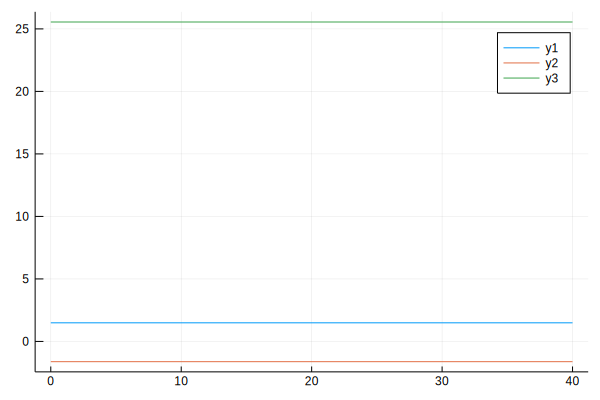

In [255]:
ŝ =  hcat(mean.(estimation_state)...)

plot(T,ŝ[1,1:end-1])
plot!(T,ŝ[2,1:end-1])
plot!(T,ŝ[3,1:end-1])


# s =  hcat(true_state...)
# plot!(sol, vars = (1))

In [ ]:
sol

In [71]:
sol.t

1287-element Array{Float64,1}:
   0.0                  
   3.5678604836301404e-5
   0.0003924646531993154
   0.0032624016752212923
   0.00905808176456279  
   0.0169564955927642   
   0.02769000245764448  
   0.04185634375662893  
   0.06024025665362463  
   0.0836852441654334   
   0.11336451506889586  
   0.14862131186030308  
   0.18703929175446188  
   ⋮                    
  99.17448947475748     
  99.25177886977121     
  99.3340481055892      
  99.40002509604705     
  99.47321520444633     
  99.54429913558833     
  99.6304176475736      
  99.73556893651245     
  99.81512588011671     
  99.88533419341042     
  99.94751447208056     
 100.0                  

In [69]:
collect(T)

1001-element Array{Float64,1}:
 0.0  
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01 
 0.011
 0.012
 ⋮    
 0.989
 0.99 
 0.991
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0  